In [1]:
# 모듈 수정 시 따로 커널 재시작 안해도 바로 적용해주는 extension.
%load_ext autoreload
%autoreload 2

%env CUDA_VISIBLE_DEVICES 0
%env DETECTRON2_DATASETS ./data/
%cd /surrogate_v2/

env: CUDA_VISIBLE_DEVICES=0
env: DETECTRON2_DATASETS=./data/
/surrogate_v2


In [2]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

from pathlib import Path
from typing import Sequence

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import utils
import models
import codec_ops
import checkpoint

from scipy.interpolate import make_interp_spline
from scipy.interpolate import interp1d

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# from detectron2.data import build_detection_train_loader
# from detectron2.utils.env import seed_all_rng
# from PIL import Image

# seed_all_rng(0)
# od_cfg = utils.get_od_cfg('detection', 'faster_rcnn_X_101_32x8d_FPN_3x')
# ds = build_detection_train_loader(od_cfg)
# Image.fromarray(next(iter(ds))[0]['image'].numpy().transpose(1, 2, 0)[..., ::-1])

## Result Plotting

### Functions

In [3]:
def parse_hyperparam_name(name):
    infos = name.split('_')
    new_infos = [
        infos[0][1:-3] + 'K',
        infos[1], infos[2], infos[3], infos[4][:3]
    ]
    new_name = '_'.join(new_infos)
    return new_name


import numpy as np
import scipy.interpolate

def BD_PSNR(R1, METRIC1, R2, METRIC2, piecewise=0):
    lR1 = np.log(R1)
    lR2 = np.log(R2)

    METRIC1 = np.array(METRIC1)
    METRIC2 = np.array(METRIC2)

    p1 = np.polyfit(lR1, METRIC1, 3)
    p2 = np.polyfit(lR2, METRIC2, 3)

    # integration interval
    min_int = max(min(lR1), min(lR2))
    max_int = min(max(lR1), max(lR2))

    # find integral
    if piecewise == 0:
        p_int1 = np.polyint(p1)
        p_int2 = np.polyint(p2)

        int1 = np.polyval(p_int1, max_int) - np.polyval(p_int1, min_int)
        int2 = np.polyval(p_int2, max_int) - np.polyval(p_int2, min_int)
    else:
        # See https://chromium.googlesource.com/webm/contributor-guide/+/master/scripts/visual_metrics.py
        lin = np.linspace(min_int, max_int, num=100, retstep=True)
        interval = lin[1]
        samples = lin[0]
        v1 = scipy.interpolate.pchip_interpolate(np.sort(lR1), METRIC1[np.argsort(lR1)], samples)
        v2 = scipy.interpolate.pchip_interpolate(np.sort(lR2), METRIC2[np.argsort(lR2)], samples)
        # Calculate the integral using the trapezoid method on the samples.
        int1 = np.trapz(v1, dx=interval)
        int2 = np.trapz(v2, dx=interval)

    # find avg diff
    avg_diff = (int2-int1)/(max_int-min_int)

    return avg_diff


def BD_RATE(R1, METRIC1, R2, METRIC2, piecewise=0):
    lR1 = np.log(R1)
    lR2 = np.log(R2)

    # rate method
    p1 = np.polyfit(METRIC1, lR1, 3)
    p2 = np.polyfit(METRIC2, lR2, 3)

    # integration interval
    min_int = max(min(METRIC1), min(METRIC2))
    max_int = min(max(METRIC1), max(METRIC2))

    # find integral
    if piecewise == 0:
        p_int1 = np.polyint(p1)
        p_int2 = np.polyint(p2)

        int1 = np.polyval(p_int1, max_int) - np.polyval(p_int1, min_int)
        int2 = np.polyval(p_int2, max_int) - np.polyval(p_int2, min_int)
    else:
        lin = np.linspace(min_int, max_int, num=100, retstep=True)
        interval = lin[1]
        samples = lin[0]
        v1 = scipy.interpolate.pchip_interpolate(np.sort(METRIC1), lR1[np.argsort(METRIC1)], samples)
        v2 = scipy.interpolate.pchip_interpolate(np.sort(METRIC2), lR2[np.argsort(METRIC2)], samples)
        # Calculate the integral using the trapezoid method on the samples.
        int1 = np.trapz(v1, dx=interval)
        int2 = np.trapz(v2, dx=interval)

    # find avg diff
    avg_exp_diff = (int2-int1)/(max_int-min_int)
    avg_diff = (np.exp(avg_exp_diff)-1)*100
    return avg_diff

### Draw

In [4]:
# base_result = pd.read_csv('out/detection/faster_rcnn_X_101_32x8d_FPN_3x/base/result.csv')

# vtm_base_result = base_result[base_result['codec'] == 'vtm']
# vvenc_base_result = base_result[base_result['codec'] == 'vvenc']
# vvenc_base_result = vvenc_base_result[vvenc_base_result.quality.isin([50,45,40,35,30,25])]

# plt.axhline(0.792190942244929, color='brown')
# plt.scatter(x=vtm_base_result['bpp'], y=vtm_base_result['metric'], label='VTM-12.0')
# plt.scatter(x=vvenc_base_result['bpp'], y=vvenc_base_result['metric'], label='VVenC-1.5.0 (preset: medium)')

# plt.grid(True)
# plt.legend(loc='lower right')
# plt.xlabel('Bit rate [bit/pixel]')
# plt.ylabel('Detection score [mAP]')
# plt.xlim(0.00, 0.90)
# # plt.xlim(0.00, 0.20)
# plt.ylim(0.50, 0.80)
# plt.savefig('result.png', dpi=300)
# plt.show()

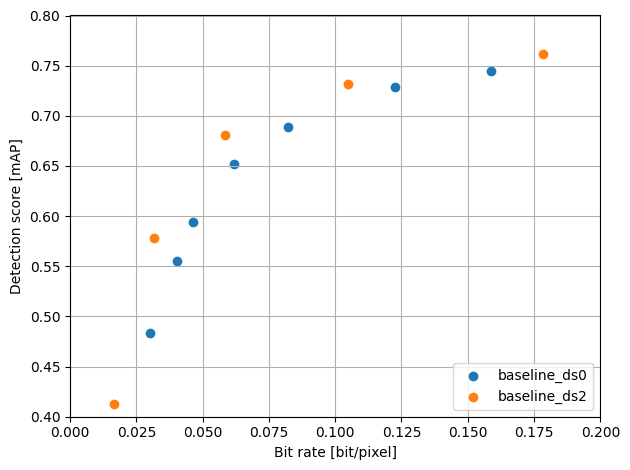

In [5]:
codec = 'vvenc'

base_result = pd.read_csv('out/detection/faster_rcnn_X_101_32x8d_FPN_3x/base/result.csv')
base_result = base_result[base_result['codec'] == codec]

base_result_ds0 = base_result[base_result['downscale'] == 0]
base_result_ds2 = base_result[base_result['downscale'] == 2]

plt.scatter(x=base_result_ds0['bpp'], y=base_result_ds0['metric'], label='baseline_ds0')
plt.scatter(x=base_result_ds2['bpp'], y=base_result_ds2['metric'], label='baseline_ds2')

plt.grid(True)

plt.legend(loc='lower right')
plt.xlabel('Bit rate [bit/pixel]')
plt.ylabel('Detection score [mAP]')

if codec == 'vvenc':
    plt.ylim(0.40, 0.80)
    plt.xlim(0.00, 0.20)
elif codec == 'vtm':
    plt.ylim(0.50, 0.80)
    plt.xlim(0.00, 0.20)

plt.savefig('result_baseline_ds.png', dpi=300)
plt.tight_layout()
plt.show()

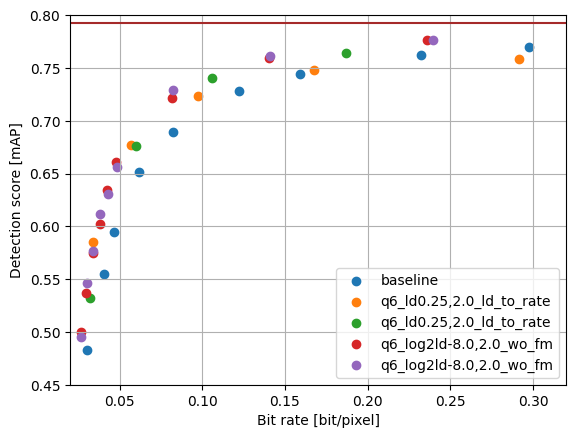

In [3]:
codec = 'vvenc'

base_result = pd.read_csv('out/detection/faster_rcnn_X_101_32x8d_FPN_3x/base/result.csv')
base_result = base_result[base_result['codec'] == codec]
base_result = base_result[base_result['downscale'] == 0]

saved_filter_paths = [
    # 'out/classification_v1/resnet18/q2_ld1.0/bs64_adam_lr0.0001',
    # 'out/detection/faster_rcnn_X_101_32x8d_FPN_3x/q2_ld1.0/s50000_bs2_adam_lr0.0001_exponential_0.1',   # 애매
    # 'out/detection/faster_rcnn_X_101_32x8d_FPN_3x/q3_ld1.0/s50000_bs2_adam_lr0.0001_exponential_0.1',
    # 'out/detection/faster_rcnn_X_101_32x8d_FPN_3x/q4_ld1.0/s50000_bs2_adam_lr0.0001_exponential_0.1',

    # 'out/detection/faster_rcnn_X_101_32x8d_FPN_3x/q6_ld0.1/s50000_bs2_adam_lr0.0001_exponential_0.1',  # X, 아예 base 언더로..
    # 'out/detection/faster_rcnn_X_101_32x8d_FPN_3x/q6_ld0.5/s50000_bs2_adam_lr0.0001_exponential_0.1',
    # 'out/detection/faster_rcnn_X_101_32x8d_FPN_3x/q6_ld1.0/s50000_bs2_adam_lr0.0001_exponential_0.1',
    # 'out/detection/faster_rcnn_X_101_32x8d_FPN_3x/q6_ld1.0_bn/s50000_bs2_adam_lr0.0001_exponential_0.1',
    # 'out/detection/faster_rcnn_X_101_32x8d_FPN_3x/q6_ld2.0/s50000_bs2_adam_lr0.0001_exponential_0.1',
    # 'out/detection/faster_rcnn_X_101_32x8d_FPN_3x/q6_ld4.0/s50000_bs2_adam_lr0.0001_exponential_0.1',

    # 'out/detection/faster_rcnn_X_101_32x8d_FPN_3x_post/q2_ld0.5/s50000_bs1_adam_lr0.0001_exponential_0.1',
    # 'out/detection/faster_rcnn_X_101_32x8d_FPN_3x_post/q6_ld_4.0/s50000_bs1_adam_lr0.0001_exponential_0.1'

    # 'out/detection/faster_rcnn_X_101_32x8d_FPN_3x/q7_ld1.0/s50000_bs2_adam_lr0.0001_exponential_0.1',
    # 'out/detection/faster_rcnn_X_101_32x8d_FPN_3x/q8_ld1.0/s50000_bs2_adam_lr0.0001_exponential_0.1',
    # 'out/detection/faster_rcnn_X_101_32x8d_FPN_3x/q8_ld0.5/s50000_bs2_adam_lr0.0001_exponential_0.1',

    # 'out/detection/faster_rcnn_X_101_32x8d_FPN_3x/q8_ld1.0_small/s50000_bs2_adam_lr0.0001_exponential_0.1',
    # 'out/detection/faster_rcnn_X_101_32x8d_FPN_3x/q8_ld1.0_smaller/s50000_bs2_adam_lr0.0001_exponential_0.1',  # X
    # 'out/detection/faster_rcnn_X_101_32x8d_FPN_3x/q8_ld0.5_smaller/s50000_bs2_adam_lr0.0001_exponential_0.1',  # X

    # 'out/detection/faster_rcnn_X_101_32x8d_FPN_3x/q8_ld1.0_only_filter/s50000_bs2_adam_lr0.0001_exponential_0.1',
    # 'out/detection/faster_rcnn_X_101_32x8d_FPN_3x/q8_ld1.0_only_filter_small/s50000_bs2_adam_lr0.0001_exponential_0.1',
    # 'out/detection/faster_rcnn_X_101_32x8d_FPN_3x/q8_ld0.5_only_filter_small/s50000_bs2_adam_lr0.0001_exponential_0.1',
    # 'out/detection/faster_rcnn_X_101_32x8d_FPN_3x/q8_ld1.0_only_filter_small_se_r8/s50000_bs2_adam_lr0.0001_exponential_0.1',

    # 'out/detection/faster_rcnn_X_101_32x8d_FPN_3x/q6_ld0.5_only_filter_small_se_r8/s50000_bs2_adam_lr0.0001_exponential_0.1',
    # 'out/detection/faster_rcnn_X_101_32x8d_FPN_3x/q6_ld4.0_only_filter_small_se_r8/s50000_bs2_adam_lr0.0001_exponential_0.1',

    # 'out/detection/faster_rcnn_X_101_32x8d_FPN_3x/q8_ld1.0_only_filter_small_se_r8/s50000_bs2_adam_lr0.0001_exponential_0.1',
    # 'out/detection/faster_rcnn_X_101_32x8d_FPN_3x/q8_ld1.0_only_filter_small_se_r16/s50000_bs2_adam_lr0.0001_exponential_0.1',
    # 'out/detection/faster_rcnn_X_101_32x8d_FPN_3x/q6_ld1.0_only_filter_small_se_r8/s50000_bs8_adam_lr0.0001_exponential_0.1',
    # 'out/detection/faster_rcnn_X_101_32x8d_FPN_3x/q6_ld1.0_only_filter_small_se_r8/s50000_bs8_adam_lr5e-05_exponential_0.1',
    # 'out/detection/faster_rcnn_X_101_32x8d_FPN_3x/q6_ld1.0_only_filter_small_se_r8/s50000_bs8_adam_lr1e-05_exponential_0.1',
    # 'out/detection/faster_rcnn_X_101_32x8d_FPN_3x/q6_ld0.5_only_filter_small_se_r8/s50000_bs8_adam_lr0.0001_exponential_0.1',
    # 'out/detection/faster_rcnn_X_101_32x8d_FPN_3x/q6_ld1.0_only_filter_small_se_r8/s100000_bs8_adam_lr0.0001_exponential_0.1',

    # 'out/detection/faster_rcnn_X_101_32x8d_FPN_3x/q6_ld0.0625_ld_to_rate/s50000_bs2_adam_lr0.0001_exponential_0.1',
    # 'out/detection/faster_rcnn_X_101_32x8d_FPN_3x/q6_ld0.125_ld_to_rate/s50000_bs2_adam_lr0.0001_exponential_0.1',
    # 'out/detection/faster_rcnn_X_101_32x8d_FPN_3x/q6_ld0.25_ld_to_rate/s50000_bs2_adam_lr0.0001_exponential_0.1',
    # 'out/detection/faster_rcnn_X_101_32x8d_FPN_3x/q6_ld0.5_ld_to_rate/s50000_bs2_adam_lr0.0001_exponential_0.1',
    # 'out/detection/faster_rcnn_X_101_32x8d_FPN_3x/q6_ld1.0_ld_to_rate/s50000_bs2_adam_lr0.0001_exponential_0.1',
    # 'out/detection/faster_rcnn_X_101_32x8d_FPN_3x/q6_ld2.0_ld_to_rate/s50000_bs8_adam_lr0.0001_exponential_0.1',
    # 'out/detection/faster_rcnn_X_101_32x8d_FPN_3x/q6_ld4.0_ld_to_rate/s50000_bs2_adam_lr0.0001_constant',
    # 'out/detection/faster_rcnn_X_101_32x8d_FPN_3x/q6_ld8.0_ld_to_rate/s50000_bs8_adam_lr0.0001_exponential_0.1',

    'out/detection/faster_rcnn_X_101_32x8d_FPN_3x/q6_ld0.25,2.0_ld_to_rate/s50000_bs8_adam_lr5e-05_exponential_0.1_ld2.0',
    'out/detection/faster_rcnn_X_101_32x8d_FPN_3x/q6_ld0.25,2.0_ld_to_rate/s50000_bs8_adam_lr5e-05_exponential_0.1_ld0.25',
    # 'out/detection/faster_rcnn_X_101_32x8d_FPN_3x/q6_log2ld-4,1_ld_to_rate/s50000_bs8_adam_lr0.0001_exponential_0.1',

    # 'out/detection/faster_rcnn_X_101_32x8d_FPN_3x/q6_ld1.0_post_only/s50000_bs2_adam_lr0.0001_exponential_0.1',
    # 'out/detection/faster_rcnn_X_101_32x8d_FPN_3x/q6_ld1.0_post_only_mse/s50000_bs2_adam_lr0.0001_exponential_0.1',

    # 'out/detection/faster_rcnn_X_101_32x8d_FPN_3x/q6_ld1.0_ds2/s50000_bs2_adam_lr0.0001_exponential_0.1',
    # 'out/detection/faster_rcnn_X_101_32x8d_FPN_3x/q6_log2ld-4,1_wo_fm/s50000_bs8_adam_lr0.0001_exponential_0.1',
    # 'out/detection/faster_rcnn_X_101_32x8d_FPN_3x/q6_log2ld-2,2_wo_fm/s50000_bs8_adam_lr0.0001_exponential_0.1',
    # 'out/detection/faster_rcnn_X_101_32x8d_FPN_3x/q6_log2ld-2,2_wo_fm/s100000_bs8_sgd_lr0.001_exponential_0.1',

    # 'out/detection/faster_rcnn_X_101_32x8d_FPN_3x/q6_log2ld-2,2_wo_fm_grad/s50000_bs8_adam_lr0.0001_constant',
    # 'out/detection/faster_rcnn_X_101_32x8d_FPN_3x/q6_log2ld-2,2_wo_fm_grad2/s50000_bs8_adam_lr0.0001_constant',

    # 'out/detection/faster_rcnn_X_101_32x8d_FPN_3x/q6_log2ld-4.0,2.0_wo_fm/s50000_bs8_adam_lr0.0001_constant',
    'out/detection/faster_rcnn_X_101_32x8d_FPN_3x/q6_log2ld-8.0,2.0_wo_fm/s50000_bs8_adam_lr0.0001_constant',
    'out/detection/faster_rcnn_X_101_32x8d_FPN_3x/q6_log2ld-8.0,2.0_wo_fm/s50000_bs8_adam_lr0.0001_constant_sd0',
]
# saved_filter_model_path = Path('out/detection/faster_rcnn_X_101_32x8d_FPN_3x/q2_ld1.0/s50000_bs2_adam_lr0.0001_exponential_0.1') # 애매
# saved_filter_model_path = Path('out/detection/faster_rcnn_X_101_32x8d_FPN_3x/q2_ld1.0/s50000_bs2_sgd_lr0.0001_exponential_0.1') # 애매
# saved_filter_model_path = Path('out/detection/faster_rcnn_X_101_32x8d_FPN_3x/q2_ld1.0/s100000_bs2_sgd_lr0.0001_constant')  # O, Good!
# saved_filter_model_path = Path('out/detection/faster_rcnn_X_101_32x8d_FPN_3x/q2_ld1.0/s200000_bs2_sgd_lr0.0001_constant')  # 애매, 오히려 overfitting 되는 느낌
# saved_filter_model_path = Path('out/detection/faster_rcnn_X_101_32x8d_FPN_3x/q1_ld1.0/s50000_bs2_adam_lr0.0001_exponential_0.1') # X
# saved_filter_model_path = Path('out/detection/faster_rcnn_X_101_32x8d_FPN_3x/q1_ld1.0/s50000_bs2_sgd_lr0.0001_constant') # X
# saved_filter_model_path = Path('out/detection/faster_rcnn_X_101_32x8d_FPN_3x/q2_ld1.0/s200000_bs2_sgd_lr0.0001_constant') # O, Good! but more fit for low bpp.
# saved_filter_model_path = Path('out/detection/faster_rcnn_X_101_32x8d_FPN_3x/q4_ld1.0/s50000_bs2_sgd_lr0.0001_constant') # O, Good
# saved_filter_model_path = Path('out/detection/faster_rcnn_X_101_32x8d_FPN_3x/q5_ld1.0/s50000_bs2_adam_lr0.0001_exponential_0.1') # O
# saved_filter_model_path = Path('out/detection/faster_rcnn_X_101_32x8d_FPN_3x/q5_ld2.0/s50000_bs2_adam_lr0.0001_exponential_0.1') # O
# saved_filter_model_path = Path('out/detection/faster_rcnn_X_101_32x8d_FPN_3x/q6_ld1.0/s50000_bs2_adam_lr0.0001_exponential_0.1')

saved_filter_paths = list(map(lambda x: Path(x) / 'result.csv', saved_filter_paths))
saved_filter_results = map(pd.read_csv, saved_filter_paths)
saved_filter_results = map(lambda x: x[x['codec'] == codec], saved_filter_results)

plt.axhline(0.792190942244929, color='brown')
plt.scatter(x=base_result['bpp'], y=base_result['metric'], label='baseline')
for filter_result, filter_path in zip(saved_filter_results, saved_filter_paths):
    # hyper_param_name = parse_hyperparam_name(filter_path.parent.name)
    label = filter_path.parent.parent.name
    if 'ld_to_rate' in label:
        # label += f" - {filter_path.parent.name.split('ld')[-1]}"
        pass
    sc = plt.scatter(x=filter_result['bpp'], y=filter_result['metric'], label=label)
    # xs = filter_result.bpp.to_list()
    # interp_fn = interp1d(filter_result.bpp, filter_result.metric, kind='quadratic')
    # new_x = np.linspace(xs[0], xs[-1])
    # new_y = interp_fn(new_x)
    # plt.plot(new_x, new_y, color=sc.get_facecolors()[0].tolist())
    # plt.plot(filter_result['bpp'], filter_result['metric'], color=sc.get_facecolors()[0].tolist())

plt.grid(True)

plt.legend(loc='lower right')
plt.xlabel('Bit rate [bit/pixel]')
plt.ylabel('Detection score [mAP]')

if codec == 'vvenc':
    # plt.xlim(0.01, 0.05)
    # plt.xlim(0.00, 0.10)
    # plt.xlim(0.00, 0.20)
    # plt.xlim(0.00, 0.35)
    plt.xlim(0.02, 0.32)
    # plt.xlim(0.00, 0.60)

    # plt.ylim(0.40, 0.65)
    plt.ylim(0.45, 0.80)
elif codec == 'vtm':
    plt.ylim(0.50, 0.80)
    plt.xlim(0.00, 0.20)

plt.savefig('result.png', dpi=300)
plt.show()

In [20]:
R1 = base_result['bpp'].to_numpy()
METRIC1 = base_result['metric'].to_numpy()

# R2 = base_result['bpp'].to_numpy()
# METRIC2 = base_result['metric'].to_numpy() * 2

R2 = filter_result['bpp'].to_numpy()
METRIC2 = filter_result['metric'].to_numpy()

# BD_PSNR(R1, METRIC1, R2, METRIC2)
BD_RATE(R1, METRIC1, R2, METRIC2)

-20.487105166040042

### Viz

In [4]:
import cv2
import pandas as pd
from PIL import Image
from pathlib import Path
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

import utils
import models
import checkpoint

base_path = Path('data/open-images-v6-etri')

img_files = sorted((base_path / 'validation').glob('*.jpg'))
annot_file = base_path / 'annotations_5k' / 'detection_validation_bbox_5k.csv'
annot_df = pd.read_csv(annot_file)

coco_label_list = open(base_path / 'annotations_5k' / 'coco_classes.txt').readlines()
coco_label_list = map(lambda x: x.strip(), coco_label_list)
coco_label_dict = {label: idx for idx, label in enumerate(coco_label_list)}

task = 'detection'
od_network_name = 'faster_rcnn_X_101_32x8d_FPN_3x'
saved_filter_model_path = Path('out/detection/faster_rcnn_X_101_32x8d_FPN_3x/q6_log2ld-8.0,2.0_wo_fm/s50000_bs8_adam_lr0.0001_constant_sd0')
surrogate_quality, is_saved_session, norm_layer = utils.inspect_session_path(saved_filter_model_path)
step = 50000
surrogate_quality = 6
norm_layer = 'cn'

od_cfg = utils.get_od_cfg(task, od_network_name)
end2end = models.EndToEndNetwork(surrogate_quality, task, norm_layer, od_cfg=od_cfg)
if is_saved_session:
    ckpt = checkpoint.Checkpoint(saved_filter_model_path)
    ckpt.load(end2end.filtering_network, step=step)

end2end.eval()
end2end.cuda()

metadata = MetadataCatalog.get(od_cfg.DATASETS.TRAIN[0])

2e5541c127c9af35


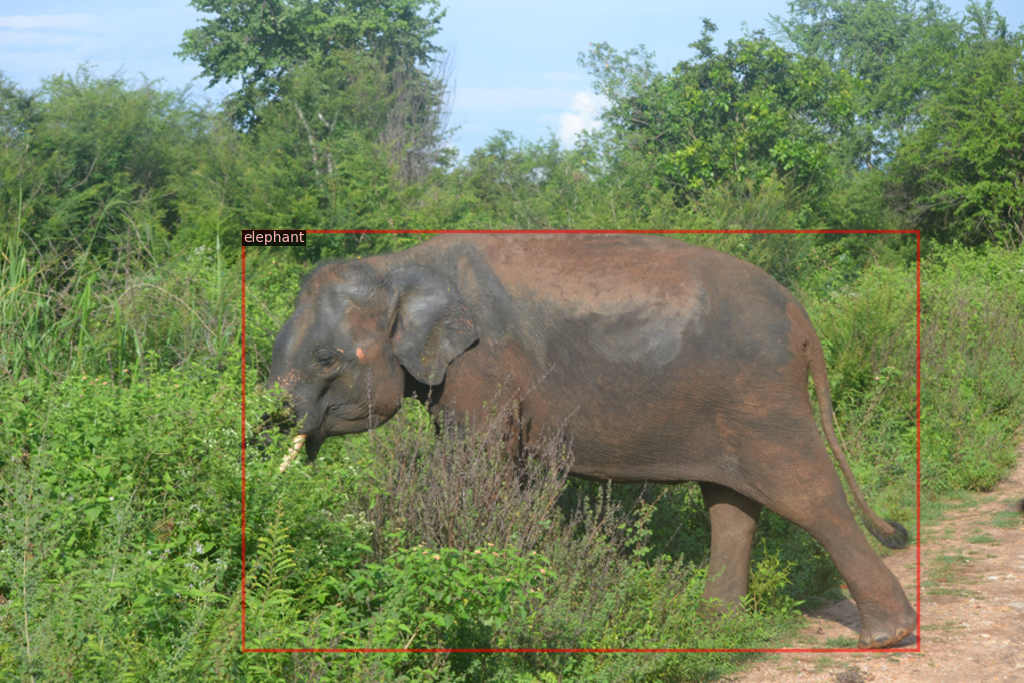

In [5]:
idx = 1500

img_file = img_files[idx]
img_arr = cv2.imread(str(img_file))
img_id = img_file.stem
annot = annot_df[annot_df.ImageID == img_id]
labels = annot['LabelName'].to_list()
normalized_boxes = annot[['XMin', 'YMin', 'XMax', 'YMax']].to_numpy()
h, w = img_arr.shape[:-1]
boxes = normalized_boxes * np.array([w, h, w, h])

vis = Visualizer(img_arr[:, :, ::-1], scale=1.0)
vis_out = vis.overlay_instances(
    boxes=boxes,
    labels=labels,
)
vis_out = Image.fromarray(vis_out.get_image())

print(img_id)
display(vis_out)

In [6]:
sample_base_path = Path('samples')
sample_path = sample_base_path / str(img_id)
sample_path.mkdir(parents=True, exist_ok=True)
vis_out.save(sample_path / 'src.png')

In [19]:
codec = 'vvenc'
downscale = 0

non_filtered_q = 48
filtered_q     = 43
non_filtered_out = end2end(img_arr, codec, non_filtered_q, downscale, eval_filtering=False)
filtered_out     = end2end(img_arr, codec, filtered_q, downscale, eval_filtering=True)

In [20]:
def filter_instance(instances, threshold):
    instances.pred_boxes.tensor = instances.pred_boxes.tensor[instances.scores >= threshold]
    instances.scores = instances.scores[instances.scores >= threshold]
    return instances

In [21]:
score_threshold = 0.5

0.0675443814055637


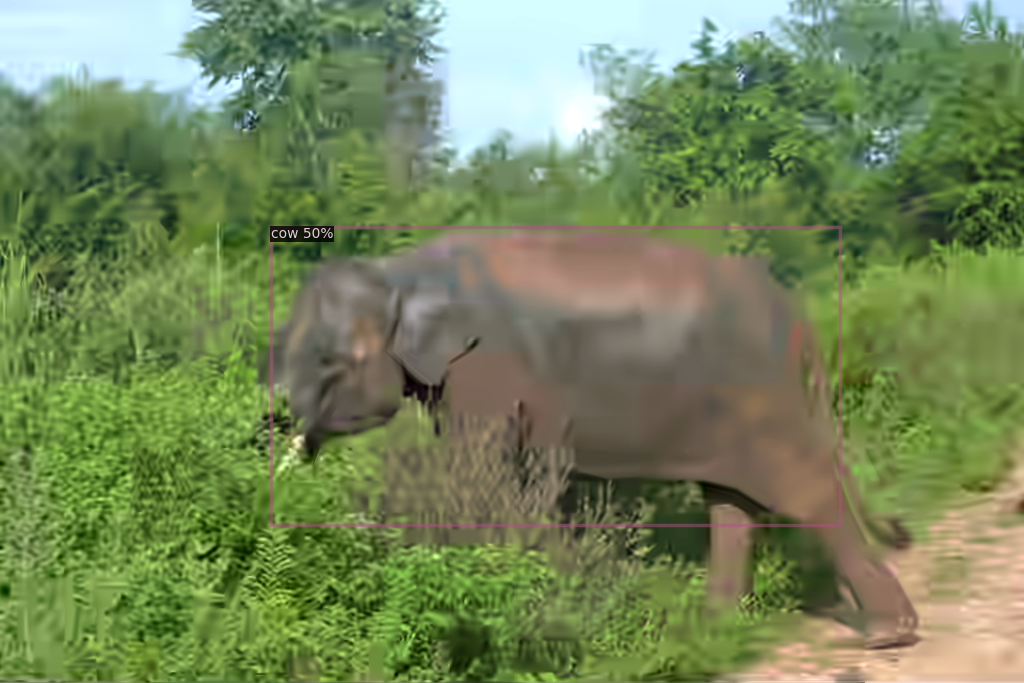

In [22]:
vis = Visualizer(
    (non_filtered_out['image']['reconstructed'] * 255).round().astype('uint8'),
    metadata, scale=1.0)
vis_out = vis.draw_instance_predictions(
    filter_instance(non_filtered_out['instances'].to('cpu'), score_threshold))
vis_img = vis_out.get_image()
vis_img = Image.fromarray(vis_img)
bpp = non_filtered_out['bpp']
print(bpp)
vis_img.save(sample_path / f"non_filtered_q{non_filtered_q}_{bpp:.4f}bpp.png")
display(vis_img)

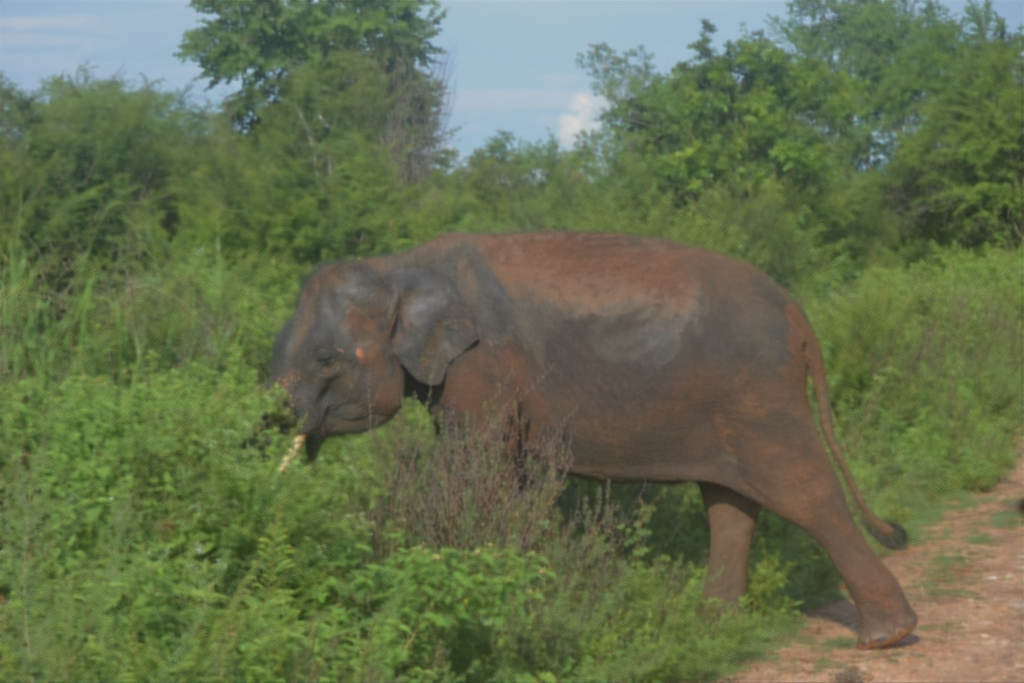

0.05818768301610542


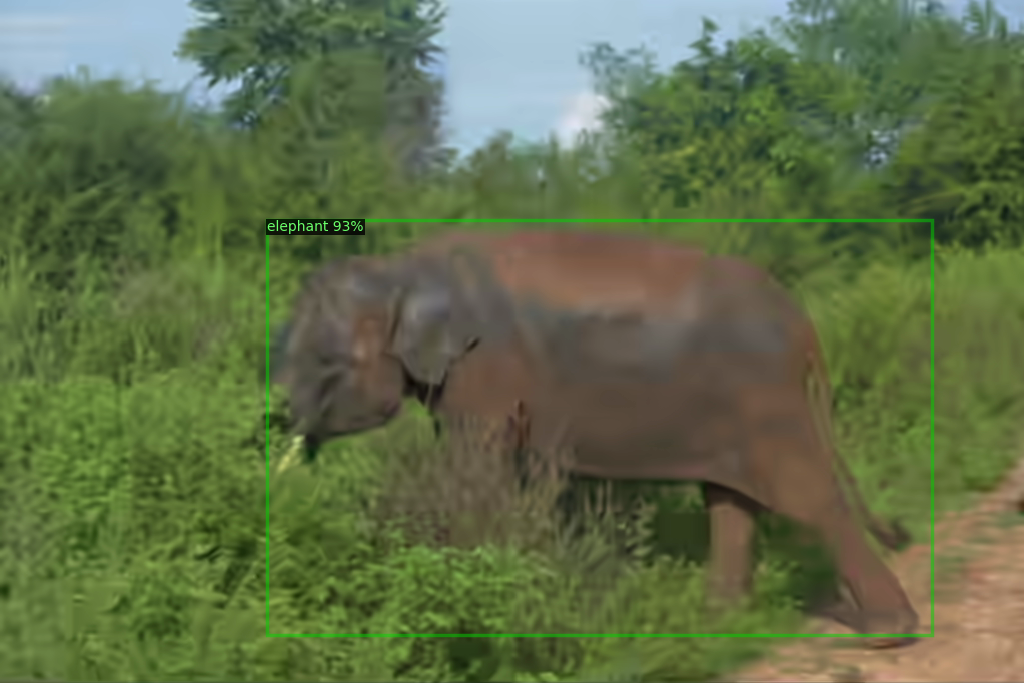

In [23]:
filt_img = (filtered_out['image']['filtered'] * 255).round().astype('uint8')
filt_img = Image.fromarray(filt_img)
display(filt_img)
filt_img.save(sample_path / f'src_filtered.png')

vis = Visualizer(
    (filtered_out['image']['reconstructed'] * 255).round().astype('uint8'),
    metadata, scale=1.0)
vis_out = vis.draw_instance_predictions(
    filter_instance(filtered_out['instances'].to('cpu'), score_threshold))
vis_img = vis_out.get_image()
vis_img = Image.fromarray(vis_img)
bpp = filtered_out['bpp']
print(bpp)
vis_img.save(sample_path / f'filtered_q{filtered_q}_{bpp:.4f}bpp.png')
display(vis_img)


In [31]:
import torch
import compressai.zoo as ca_zoo
from fvcore.nn import FlopCountAnalysis, flop_count_table

In [5]:
model = ca_zoo.bmshj2018_factorized(quality=8)
model.eval()
input = torch.ones((1, 3, 640, 1280))
flops = FlopCountAnalysis(model, input)
print(flop_count_table(flops))
print(sum([param.numel() for param in model.parameters()]) // 1e6)

| module                         | #parameters or shape   | #flops    |
|:-------------------------------|:-----------------------|:----------|
| model                          | 7.031M                 | 0.154T    |
|  entropy_bottleneck            |  19.52K                |  67.584M  |
|   entropy_bottleneck._matrix0  |   (320, 3, 1)          |           |
|   entropy_bottleneck._bias0    |   (320, 3, 1)          |           |
|   entropy_bottleneck._factor0  |   (320, 3, 1)          |           |
|   entropy_bottleneck._matrix1  |   (320, 3, 3)          |           |
|   entropy_bottleneck._bias1    |   (320, 3, 1)          |           |
|   entropy_bottleneck._factor1  |   (320, 3, 1)          |           |
|   entropy_bottleneck._matrix2  |   (320, 3, 3)          |           |
|   entropy_bottleneck._bias2    |   (320, 3, 1)          |           |
|   entropy_bottleneck._factor2  |   (320, 3, 1)          |           |
|   entropy_bottleneck._matrix3  |   (320, 3, 3)          |     

In [7]:
model = ca_zoo.bmshj2018_hyperprior(quality=8)
model.eval()
input = torch.ones((1, 3, 640, 1280))
flops = FlopCountAnalysis(model, input)
print(flop_count_table(flops))
print(sum([param.numel() for param in model.parameters()]) // 1e6)

| module                         | #parameters or shape   | #flops    |
|:-------------------------------|:-----------------------|:----------|
| model                          | 11.816M                | 0.159T    |
|  entropy_bottleneck            |  11.712K               |  2.534M   |
|   entropy_bottleneck._matrix0  |   (192, 3, 1)          |           |
|   entropy_bottleneck._bias0    |   (192, 3, 1)          |           |
|   entropy_bottleneck._factor0  |   (192, 3, 1)          |           |
|   entropy_bottleneck._matrix1  |   (192, 3, 3)          |           |
|   entropy_bottleneck._bias1    |   (192, 3, 1)          |           |
|   entropy_bottleneck._factor1  |   (192, 3, 1)          |           |
|   entropy_bottleneck._matrix2  |   (192, 3, 3)          |           |
|   entropy_bottleneck._bias2    |   (192, 3, 1)          |           |
|   entropy_bottleneck._factor2  |   (192, 3, 1)          |           |
|   entropy_bottleneck._matrix3  |   (192, 3, 3)          |     

In [8]:
model = ca_zoo.mbt2018(quality=8)
model.eval()
input = torch.ones((1, 3, 640, 1280))
flops = FlopCountAnalysis(model, input)
print(flop_count_table(flops))
print(sum([param.numel() for param in model.parameters()]) // 1e6)

| module                         | #parameters or shape   | #flops    |
|:-------------------------------|:-----------------------|:----------|
| model                          | 25.505M                | 0.194T    |
|  entropy_bottleneck            |  11.712K               |  2.534M   |
|   entropy_bottleneck._matrix0  |   (192, 3, 1)          |           |
|   entropy_bottleneck._bias0    |   (192, 3, 1)          |           |
|   entropy_bottleneck._factor0  |   (192, 3, 1)          |           |
|   entropy_bottleneck._matrix1  |   (192, 3, 3)          |           |
|   entropy_bottleneck._bias1    |   (192, 3, 1)          |           |
|   entropy_bottleneck._factor1  |   (192, 3, 1)          |           |
|   entropy_bottleneck._matrix2  |   (192, 3, 3)          |           |
|   entropy_bottleneck._bias2    |   (192, 3, 1)          |           |
|   entropy_bottleneck._factor2  |   (192, 3, 1)          |           |
|   entropy_bottleneck._matrix3  |   (192, 3, 3)          |     

In [9]:
model = ca_zoo.mbt2018_mean(quality=8)
model.eval()
input = torch.ones((1, 3, 640, 1280))
flops = FlopCountAnalysis(model, input)
print(flop_count_table(flops))
print(sum([param.numel() for param in model.parameters()]) // 1e6)

| module                         | #parameters or shape   | #flops    |
|:-------------------------------|:-----------------------|:----------|
| model                          | 17.562M                | 0.168T    |
|  entropy_bottleneck            |  11.712K               |  2.534M   |
|   entropy_bottleneck._matrix0  |   (192, 3, 1)          |           |
|   entropy_bottleneck._bias0    |   (192, 3, 1)          |           |
|   entropy_bottleneck._factor0  |   (192, 3, 1)          |           |
|   entropy_bottleneck._matrix1  |   (192, 3, 3)          |           |
|   entropy_bottleneck._bias1    |   (192, 3, 1)          |           |
|   entropy_bottleneck._factor1  |   (192, 3, 1)          |           |
|   entropy_bottleneck._matrix2  |   (192, 3, 3)          |           |
|   entropy_bottleneck._bias2    |   (192, 3, 1)          |           |
|   entropy_bottleneck._factor2  |   (192, 3, 1)          |           |
|   entropy_bottleneck._matrix3  |   (192, 3, 3)          |     

In [10]:
model = ca_zoo.cheng2020_anchor(quality=6)
model.eval()
input = torch.ones((1, 3, 640, 1280))
flops = FlopCountAnalysis(model, input)
print(flop_count_table(flops))
print(sum([param.numel() for param in model.parameters()]) // 1e6)

| module                         | #parameters or shape   | #flops     |
|:-------------------------------|:-----------------------|:-----------|
| model                          | 26.599M                | 0.784T     |
|  entropy_bottleneck            |  11.712K               |  2.534M    |
|   entropy_bottleneck._matrix0  |   (192, 3, 1)          |            |
|   entropy_bottleneck._bias0    |   (192, 3, 1)          |            |
|   entropy_bottleneck._factor0  |   (192, 3, 1)          |            |
|   entropy_bottleneck._matrix1  |   (192, 3, 3)          |            |
|   entropy_bottleneck._bias1    |   (192, 3, 1)          |            |
|   entropy_bottleneck._factor1  |   (192, 3, 1)          |            |
|   entropy_bottleneck._matrix2  |   (192, 3, 3)          |            |
|   entropy_bottleneck._bias2    |   (192, 3, 1)          |            |
|   entropy_bottleneck._factor2  |   (192, 3, 1)          |            |
|   entropy_bottleneck._matrix3  |   (192, 3, 3)   

In [12]:
model = ca_zoo.cheng2020_attn(quality=6)
model.eval()
input = torch.ones((1, 3, 640, 1280))
flops = FlopCountAnalysis(model, input)
print(flop_count_table(flops))
print(sum([param.numel() for param in model.parameters()]) // 1e6)

| module                         | #parameters or shape   | #flops     |
|:-------------------------------|:-----------------------|:-----------|
| model                          | 29.632M                | 0.866T     |
|  entropy_bottleneck            |  11.712K               |  2.534M    |
|   entropy_bottleneck._matrix0  |   (192, 3, 1)          |            |
|   entropy_bottleneck._bias0    |   (192, 3, 1)          |            |
|   entropy_bottleneck._factor0  |   (192, 3, 1)          |            |
|   entropy_bottleneck._matrix1  |   (192, 3, 3)          |            |
|   entropy_bottleneck._bias1    |   (192, 3, 1)          |            |
|   entropy_bottleneck._factor1  |   (192, 3, 1)          |            |
|   entropy_bottleneck._matrix2  |   (192, 3, 3)          |            |
|   entropy_bottleneck._bias2    |   (192, 3, 1)          |            |
|   entropy_bottleneck._factor2  |   (192, 3, 1)          |            |
|   entropy_bottleneck._matrix3  |   (192, 3, 3)   

In [2]:
# 모듈 수정 시 따로 커널 재시작 안해도 바로 적용해주는 extension.
%load_ext autoreload
%autoreload 2

%env CUDA_VISIBLE_DEVICES 3
%env DETECTRON2_DATASETS ./data/
%cd /surrogate_v2/

env: CUDA_VISIBLE_DEVICES=3
env: DETECTRON2_DATASETS=./data/
/surrogate_v2


In [14]:
import torch
from fvcore.nn import FlopCountAnalysis, flop_count_table
from detectron2.utils.analysis import flop_count_operators
from detectron2.data import build_detection_train_loader

import utils
import models

cfg = utils.get_od_cfg('detection', 'faster_rcnn_X_101_32x8d_FPN_3x')
# cfg = utils.get_od_cfg('detection', 'faster_rcnn_R_50_C4_1x')
cfg.SOLVER.IMS_PER_BATCH = 2
surrogate_quality = 6
model = models.EndToEndNetwork(surrogate_quality, 'detection', od_cfg=cfg)
model.train()
model.cuda()


dataloader = build_detection_train_loader(cfg)
input = next(iter(dataloader))

In [16]:
losses = model(input, [0.5, 4.0])
losses

{'r': tensor(0.5016, device='cuda:0', grad_fn=<MeanBackward0>),
 'd': tensor(0.6845, device='cuda:0', grad_fn=<AddBackward0>)}

In [28]:
inputs = []
input_it = iter(dataloader)
for _ in range(10):
    inputs.append(next(input_it)[0])

In [29]:
inputs[0]['instances']

Instances(num_instances=3, image_height=704, image_width=939, fields=[gt_boxes: Boxes(tensor([[418.9113, 225.7347, 628.1910, 375.3933],
        [613.1083, 238.5387, 909.7296, 385.9533],
        [272.9409, 342.5400, 503.6855, 473.0147]])), gt_classes: tensor([50, 50, 50])])

In [6]:
from torchvision.transforms import Resize

def downscale_inputs(inputs):
    for input in inputs:
        h, w = input['image'].shape[1:]
        new_h, new_w = map(lambda x: round(x / 2), (h, w))
        ratio_h, ratio_w = new_h / h, new_w / w
        input['image'] = Resize((new_h, new_w), antialias=True)(input['image'])
        input['instances'].gt_boxes.tensor *= torch.as_tensor(
            [ratio_w, ratio_h] * 2, device=input['instances'].gt_boxes.tensor.device)
        input['instances']._image_size = (new_h, new_w)
        

In [7]:
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from PIL import Image

In [41]:
target_fields = inputs[3]['instances'].get_fields()
# target_fields.get("gt_boxes", None).tensor.numpy()
# target_fields.get('gt_classes')
metadata = MetadataCatalog.get(cfg.DATASETS.TRAIN[0])
len(metadata.thing_classes)

80

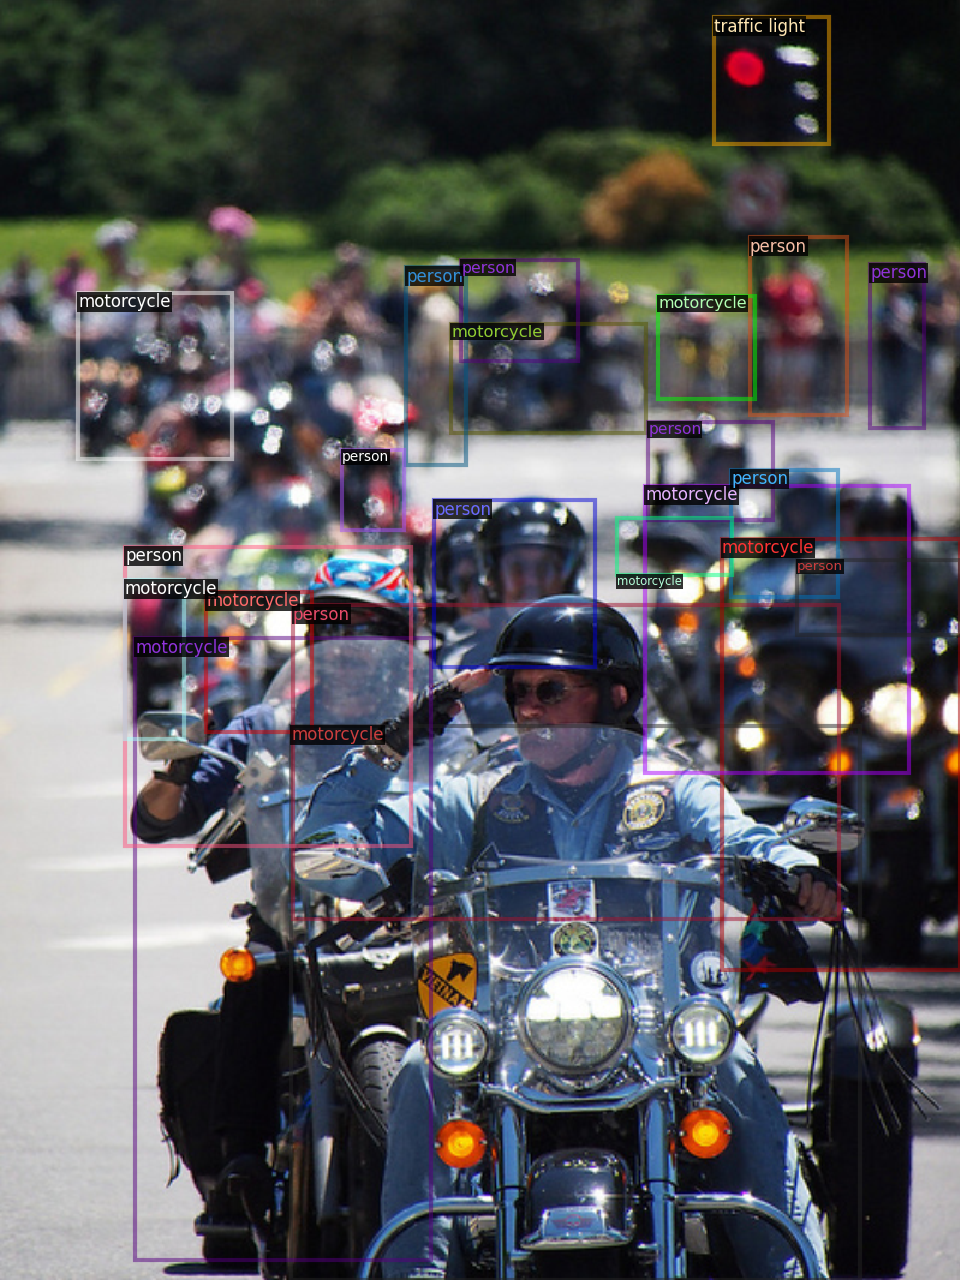

(960, 1280)


In [42]:
idx = 3

metadata = MetadataCatalog.get(cfg.DATASETS.TRAIN[0])
v = Visualizer(
    inputs[idx]['image'].numpy().transpose(1, 2, 0)[:,:,::-1],
    # metadata,
    scale=1.2)
target_fields = inputs[idx]['instances'].get_fields()
out = v.overlay_instances(
    labels=[metadata.thing_classes[i] for i in target_fields["gt_classes"]],
    boxes=target_fields.get("gt_boxes", None).tensor.numpy(),
)

img = Image.fromarray(out.get_image())
display(img)
print(img.size)

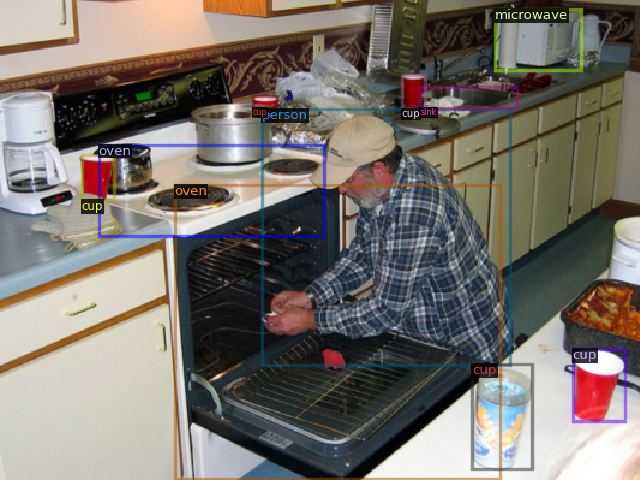

(640, 480)


In [35]:
idx = 3

from copy import deepcopy
ds_inputs = deepcopy(inputs)
downscale_inputs(ds_inputs)

metadata = MetadataCatalog.get(cfg.DATASETS.TRAIN[0])
v = Visualizer(
    ds_inputs[idx]['image'].numpy().transpose(1, 2, 0)[:,:,::-1],
    metadata,
    scale=1.2)
target_fields = ds_inputs[idx]['instances'].get_fields()
out = v.overlay_instances(
    labels=[metadata.thing_classes[i] for i in target_fields["gt_classes"]],
    boxes=target_fields.get("gt_boxes", None),
)

img = Image.fromarray(out.get_image())
display(img)
print(img.size)

In [ ]:
flops = FlopCountAnalysis(model, input)
print(flop_count_table(flops))
print(sum([param.numel() for param in model.parameters()]) // 1e6)

In [7]:
import torch
from torch.profiler import profile, record_function, ProfilerActivity
from fvcore.nn import FlopCountAnalysis, flop_count_table
from detectron2.utils.analysis import flop_count_operators
from detectron2.data import build_detection_train_loader

import utils
import models

# cfg = utils.get_od_cfg('detection', 'faster_rcnn_X_101_32x8d_FPN_3x')
cfg = utils.get_od_cfg('detection', 'faster_rcnn_R_50_C4_1x')
cfg.SOLVER.IMS_PER_BATCH = 1
surrogate_quality = 8
model = models.EndToEndNetwork(surrogate_quality, 'detection', od_cfg=cfg)
model.train()
model.cuda()

dataloader = build_detection_train_loader(cfg)
input = next(iter(dataloader))

In [11]:
model = ca_zoo.mbt2018(quality=8, pretrained=True)
model.cuda()

input = torch.ones((2, 3, 1280, 640)).cuda()

In [20]:
with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], profile_memory=True, record_shapes=True) as prof:
    with record_function("model_inference"):
        model(input)

In [23]:
print(prof.key_averages().table(sort_by="self_cuda_memory_usage", row_limit=30))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                            aten::empty         0.24%       1.681ms        66.97%     461.867ms       1.776ms       0.000us         0.00%       0.000us       0.000us       1.84 Mb       1.84 Mb       4.56 Gb       4.56 G

In [1]:
import torch

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
a = torch.ones((2, 16, 1, 1))
b = torch.ones((2, 16, 1024, 768))
(a * b).shape

torch.Size([2, 16, 1024, 768])

In [5]:
from pathlib import Path

In [6]:
'hello' / Path('hello')

PosixPath('hello/hello')